<a href="https://colab.research.google.com/github/srilav/audioml/blob/master/M6_NB_MiniProject_3_BitCoin_Forecasting_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Bitcoin price forecasting using ARMA

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARMA model and forecast the bit coin price

## Dataset



Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a whitepaper by the mysterious and pseudonymous Satoshi Nakamoto. The identity of the person or persons who created the technology is still a mystery. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.

Data Description
This dataset provides the history of daily prices of Bitcoin. The data starts from 17-Sep-2014 and is updated till 09-July-2021. All the column descriptions are provided below.

* Date: Day/Month/Year
* Open: Price from the first transaction of a trading day
* High: Maximum price in a trading day
* Low: Minimum price in a trading day
* Close: Price from the last transaction of a trading day
* Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
* Volume: Number of units traded in a day

## Problem Statement

Perform EDA and forecast the Bitcoin price using ARMA model on timeseries (bitcoin) data.

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/BTC.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages 

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import itertools

### Load the data and perform EDA [2 points]

Hint: Refer to this ['Bitcoin dataset EDA'](https://medium.com/@hamzaahmad86/exploratory-data-analysis-of-cryptocurrency-historical-data-d8ec719641e7)

In [ ]:
filepath='/content/BTC.csv'
df = pd.read_csv(filepath, parse_dates=True)
df['Date']  = pd.to_datetime(df['Date'])
df1 = df.set_index('Date')
df1.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0


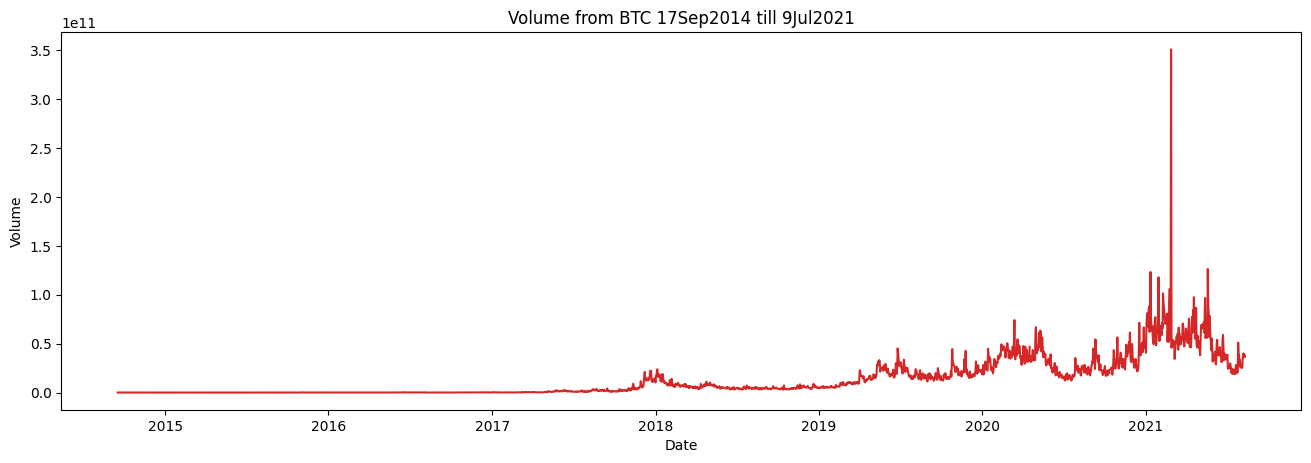

In [ ]:
# Define function to plot the time series
def plot_df(df1, x, y, title="", xlabel='Date', ylabel='Volume', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df1['Volume'], x=df1.index, y=df1['Volume'], title='Volume from BTC 17Sep2014 till 9Jul2021')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2520 entries, 2014-09-17 to 2021-08-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   float64
dtypes: float64(6)
memory usage: 137.8 KB


In [ ]:
df1.isna().sum()

Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [ ]:
all_inf_or_nan = df1.isin([np.inf, -np.inf, np.nan]).all(axis='columns')
df2 = df1[~all_inf_or_nan]

In [ ]:
df2.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### Analyze the correlation (heatmap) of all the features

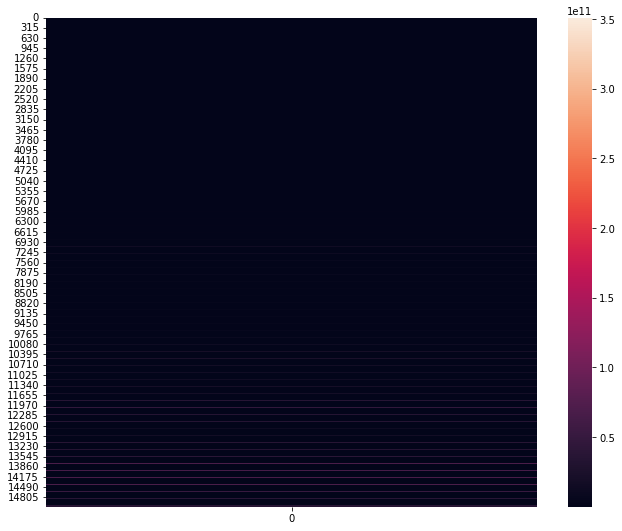

In [ ]:
# YOUR CODE HERE
import seaborn as sb
fig, ax = plt.subplots(figsize=(11, 9))
data = np.asarray(df2).reshape(15096,1)
sb.heatmap(data)
plt.show()

### Test the Stationarity using Augmented Dicky Fuller Test [1 point]

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
# YOUR CODE HERE
fuller_test = adfuller(df2['Volume'])
fuller_test  

(-1.4474545869342568,
 0.559326431516235,
 27,
 2488,
 {'1%': -3.4329810529006184,
  '10%': -2.5673887817601657,
  '5%': -2.862702382731847},
 120434.26978880678)

In [ ]:
def test_p_value(data):
    """ Return Data is stationary if p-value <= 0.05 """
    fuller_test = adfuller(data)
    print('P-value: ',fuller_test[1])
    if fuller_test[1] <= 0.05:
        print('Reject null hypothesis, data is stationary')
    else:
        print('Do not reject null hypothesis, data is not stationary')

# ADF test for Production series
test_p_value(df2['Volume'])

P-value:  0.559326431516235
Do not reject null hypothesis, data is not stationary


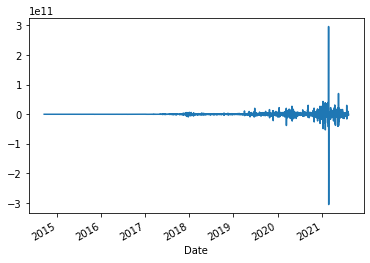

In [ ]:
# Perform First order differencing
df2['First_diff'] = df2['Volume'] - df2['Volume'].shift(1)
df2['First_diff'].plot()

In [ ]:
# ADF test for First order difference
test_p_value(df2['First_diff'].dropna())

P-value:  7.006518742484653e-28
Reject null hypothesis, data is stationary


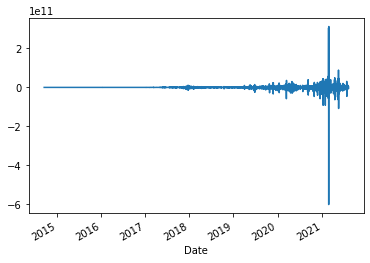

In [ ]:
# Perform Second order differencing
df2['Second_diff'] = df2['First_diff'] - df2['First_diff'].shift(1)
df2['Second_diff'].plot()

In [ ]:
# ADF test for Second order difference
test_p_value(df2['Second_diff'].dropna())

P-value:  2.022250197720854e-30
Reject null hypothesis, data is stationary


### Identify the trends and seasonality from the given time series data [2 points]

* Apply seasonal decompose and plot the results
* Check the stationarity of data using rolling mean and rolling standard deviation.
* Make the time series data stationary
  * Apply a log transformation to reduce the variance of the series
  * Eliminate the Trend and Seasonality by Differencing 

**Note:** Ensure timeseries without NaN, inf, -inf values, Replace with 0 if found.

Read more about stationarity of a timeseries in the following [link](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [ ]:
decomp = seasonal_decompose(df2['Volume'])
fig = decomp.plot()
fig.set_size_inches(14,7)

ValueError: ignored

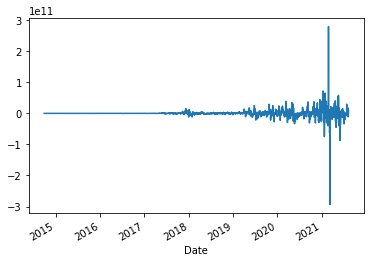

In [ ]:
# YOUR CODE HERE
# Perform Seasonal differencing
df2['Seasonal_diff'] = df2['Volume'] - df2['Volume'].shift(12)
df2['Seasonal_diff'].plot()

In [ ]:
# ADF test for Seasonal difference
test_p_value(df2['Seasonal_diff'].dropna())

P-value:  4.484080936395087e-14
Reject null hypothesis, data is stationary


### Test the Stationarity using Augmented Dicky Fuller Test [1 point]

Verify the stationarity post differencing, using ADF

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
adf = adfuller(df2['Volume'], maxlag=None, autolag='aic',
                               store=True, regresults=True)
adf

(-1.4474545869342568,
 0.559326431516235,
 {'1%': -3.4329810529006184,
  '10%': -2.5673887817601657,
  '5%': -2.862702382731847},
 <statsmodels.tsa.stattools.ResultsStore at 0x7f9bfd8b0550>)

In [ ]:
# Decompose time series
decomp = seasonal_decompose(df2['Volume'])
fig = decomp.plot()
fig.set_size_inches(14,7)

ValueError: ignored

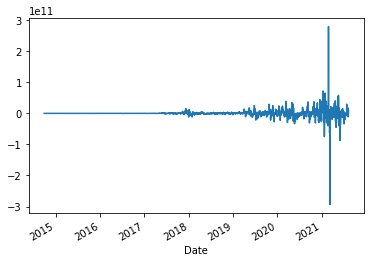

In [ ]:
# YOUR CODE HERE
# Perform Seasonal differencing
df2['Seasonal_diff'] = df2['Volume'] - df2['Volume'].shift(12)
df2['Seasonal_diff'].plot()

In [ ]:
# ADF test for Seasonal difference
test_p_value(df2['Seasonal_diff'].dropna())

P-value:  4.484080936395087e-14
Reject null hypothesis, data is stationary


### Auto Correlation Plot [1 point]

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time.

* Plot the auto correlation function (ACF and PACF)
* Analyse ACF and PACF plots and define AR (p) and MA(q) terms

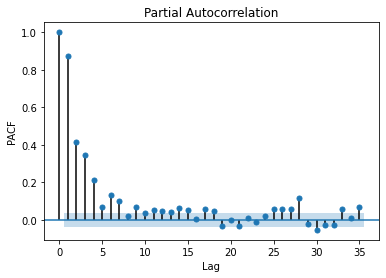

In [ ]:
# YOUR CODE HERE
# Visualize PACF
plot_pacf(df2['Volume'])
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.show()

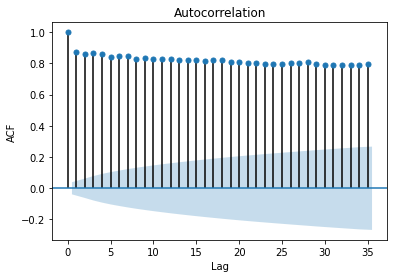

In [ ]:
# YOUR CODE HERE
# Visualize PACF
plot_acf(df2['Volume'])
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

In [ ]:
# Create AR(1) model
ar = sm.tsa.ARMA(df2['Volume'], order=(1, 0))
r1 = ar.fit()
print(r1.summary())

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                 2516
Model:                     ARMA(1, 0)   Log Likelihood              -61415.863
Method:                       css-mle   S.D. of innovations     9656497973.894
Date:                Wed, 09 Mar 2022   AIC                         122837.726
Time:                        11:46:13   BIC                         122855.218
Sample:                             0   HQIC                        122844.075
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.314e+10   1.51e+09      8.708      0.000    1.02e+10    1.61e+10
ar.L1.Volume     0.8728      0.010     89.805      0.000       0.854       0.892
                                    Roots   

In [ ]:
r1.aic

39798.56691849409

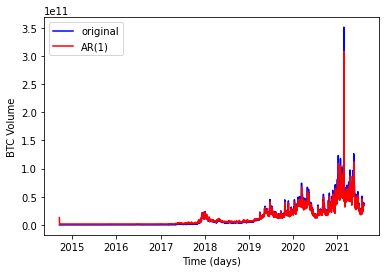

In [ ]:
# Visualize prediction

plt.plot(df2['Volume'], 'b', label="original")
plt.plot(r1.predict(), 'r', label="AR(1)")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("BTC Volume")
plt.show()

### Train the Auto Regressive model [1 point]

Hint: sm.tsa.AR()

In [ ]:
# YOUR CODE HERE
# Create an AR model
regr = sm.tsa.AR(df2['Volume']).fit(maxlag=2)
# Predict next 23 instances
fore = regr.predict()

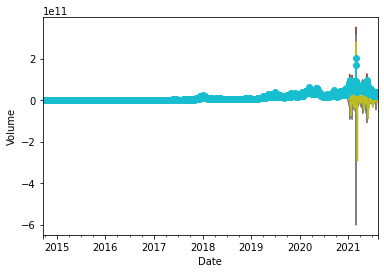

In [ ]:
# Visualize forecasts
df2["2021":].plot(xlabel="Time", ylabel="Volume", legend=False)
fore.plot(marker="o")
plt.show()

### ARMA Model [1 point]

* Train the ARMA model on timeseries data and print AIC value

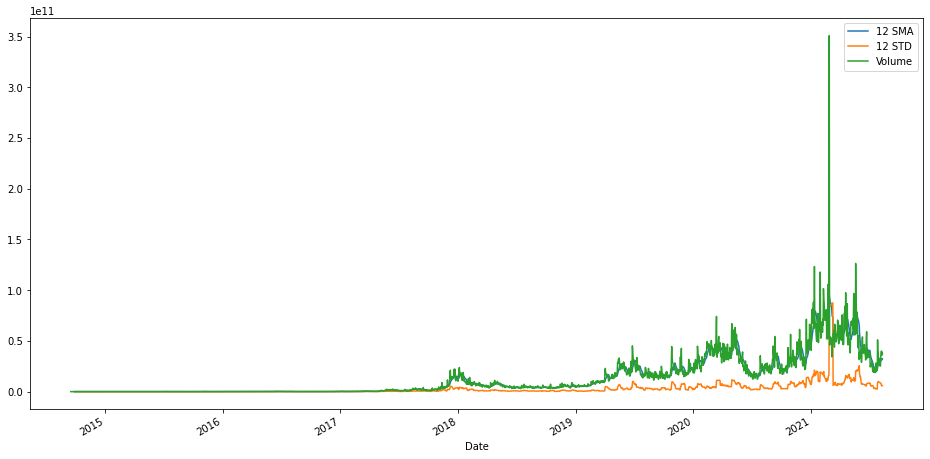

In [ ]:
# YOUR CODE HERE for ARMA Model
# 12 month simple moving average and standard deviation
df2['Volume'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df2['Volume'].rolling(12).std().plot(label='12 STD')
df2['Volume'].plot()
plt.legend()
plt.show()


#### Plot the predictions for timeseries data [1 point]

In [ ]:
# YOUR CODE HERE
# Decompose time series
decomp = seasonal_decompose(df2['Volume'])
fig = decomp.plot()
fig.set_size_inches(14,7)

ValueError: ignored

Text(0, 0.5, 'PACF')

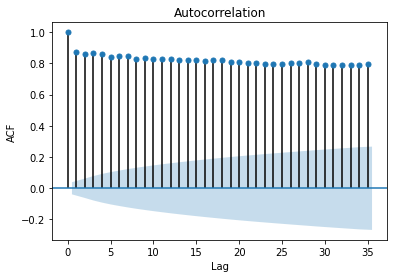

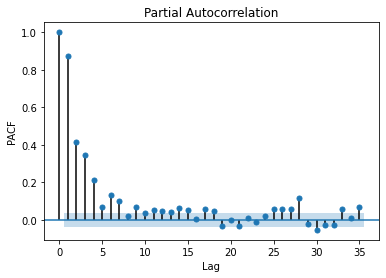

In [ ]:
# Visualize ACF and PACF for Production series
p1 = plot_acf(df2['Volume']); plt.xlabel("Lag"); plt.ylabel("ACF")
p2 = plot_pacf(df2['Volume']); plt.xlabel("Lag"); plt.ylabel("PACF")

In [ ]:
# Create ARMA(p=6, q=10) model
model = sm.tsa.ARMA(df2['Volume'],order=(9,9))
# Fit model
results = model.fit()
results.summary()

ValueError: ignored

In [ ]:
# Predict present data
df2['prediction'] = results.predict()
df2[['Volume','prediction']].plot(figsize=(12,8))
plt.ylabel("BTC Bitcoin")
plt.show()

NameError: ignored

### Report Analysis

* Discuss how sudden effects of bitcoin price affects the model parameters
* State your observations about the trend and seasonality of the timeseries data
* Discuss how you selected ARMA (p and q) terms.
* Interpret the AIC value obtained for the ARMA model